In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from scipy.stats import kstest, f_oneway

In [70]:
RESULTS = 'results/'
PLOTS = f'{RESULTS}plots/'
REPORTS = f'{RESULTS}reports'
BFE = f'{RESULTS}best_fitness_execution/'

In [71]:
parametricos = pd.read_csv(f"{BFE}best_fit_per_config_parametric.csv")
resultados = pd.read_csv(f"{RESULTS}resultados.csv")

In [72]:
def normality_test(sample): 
        standarized_sample = (sample - np.mean(sample)) / np.std(sample, ddof=1)
        return kstest(standarized_sample, "norm", alternative='two-sided').pvalue

def anova_test(samples):
        return f_oneway(*samples).pvalue

In [73]:
def print_hist_plots(df, plot_name):
    fig, axs = plt.subplots(ceil(len(df.columns)/2), 2, figsize=(20, 20))
    for col,ax in zip(df.columns, axs.flatten()):
        ax.hist(df[col], density=True)
        ax.set_title(col)
        xlim = ax.get_xlim()
        
        # kernel density estimate
        df[col].plot.density(color='k', alpha=0.5, ax=ax)
        
        ax.set_xlim(xlim)
        ax.legend(labels=['KDE'], frameon=False)
        ax.text(0.98, 0.9, f"p-value={normality_test(df[col]):.5f}", verticalalignment ='top', horizontalalignment ='right', transform = ax.transAxes, color ='black', fontsize = 12)
        
        ax.set_title(col, fontsize=14, pad=15)
        
    fig.savefig(f"{PLOTS}{plot_name}.png")

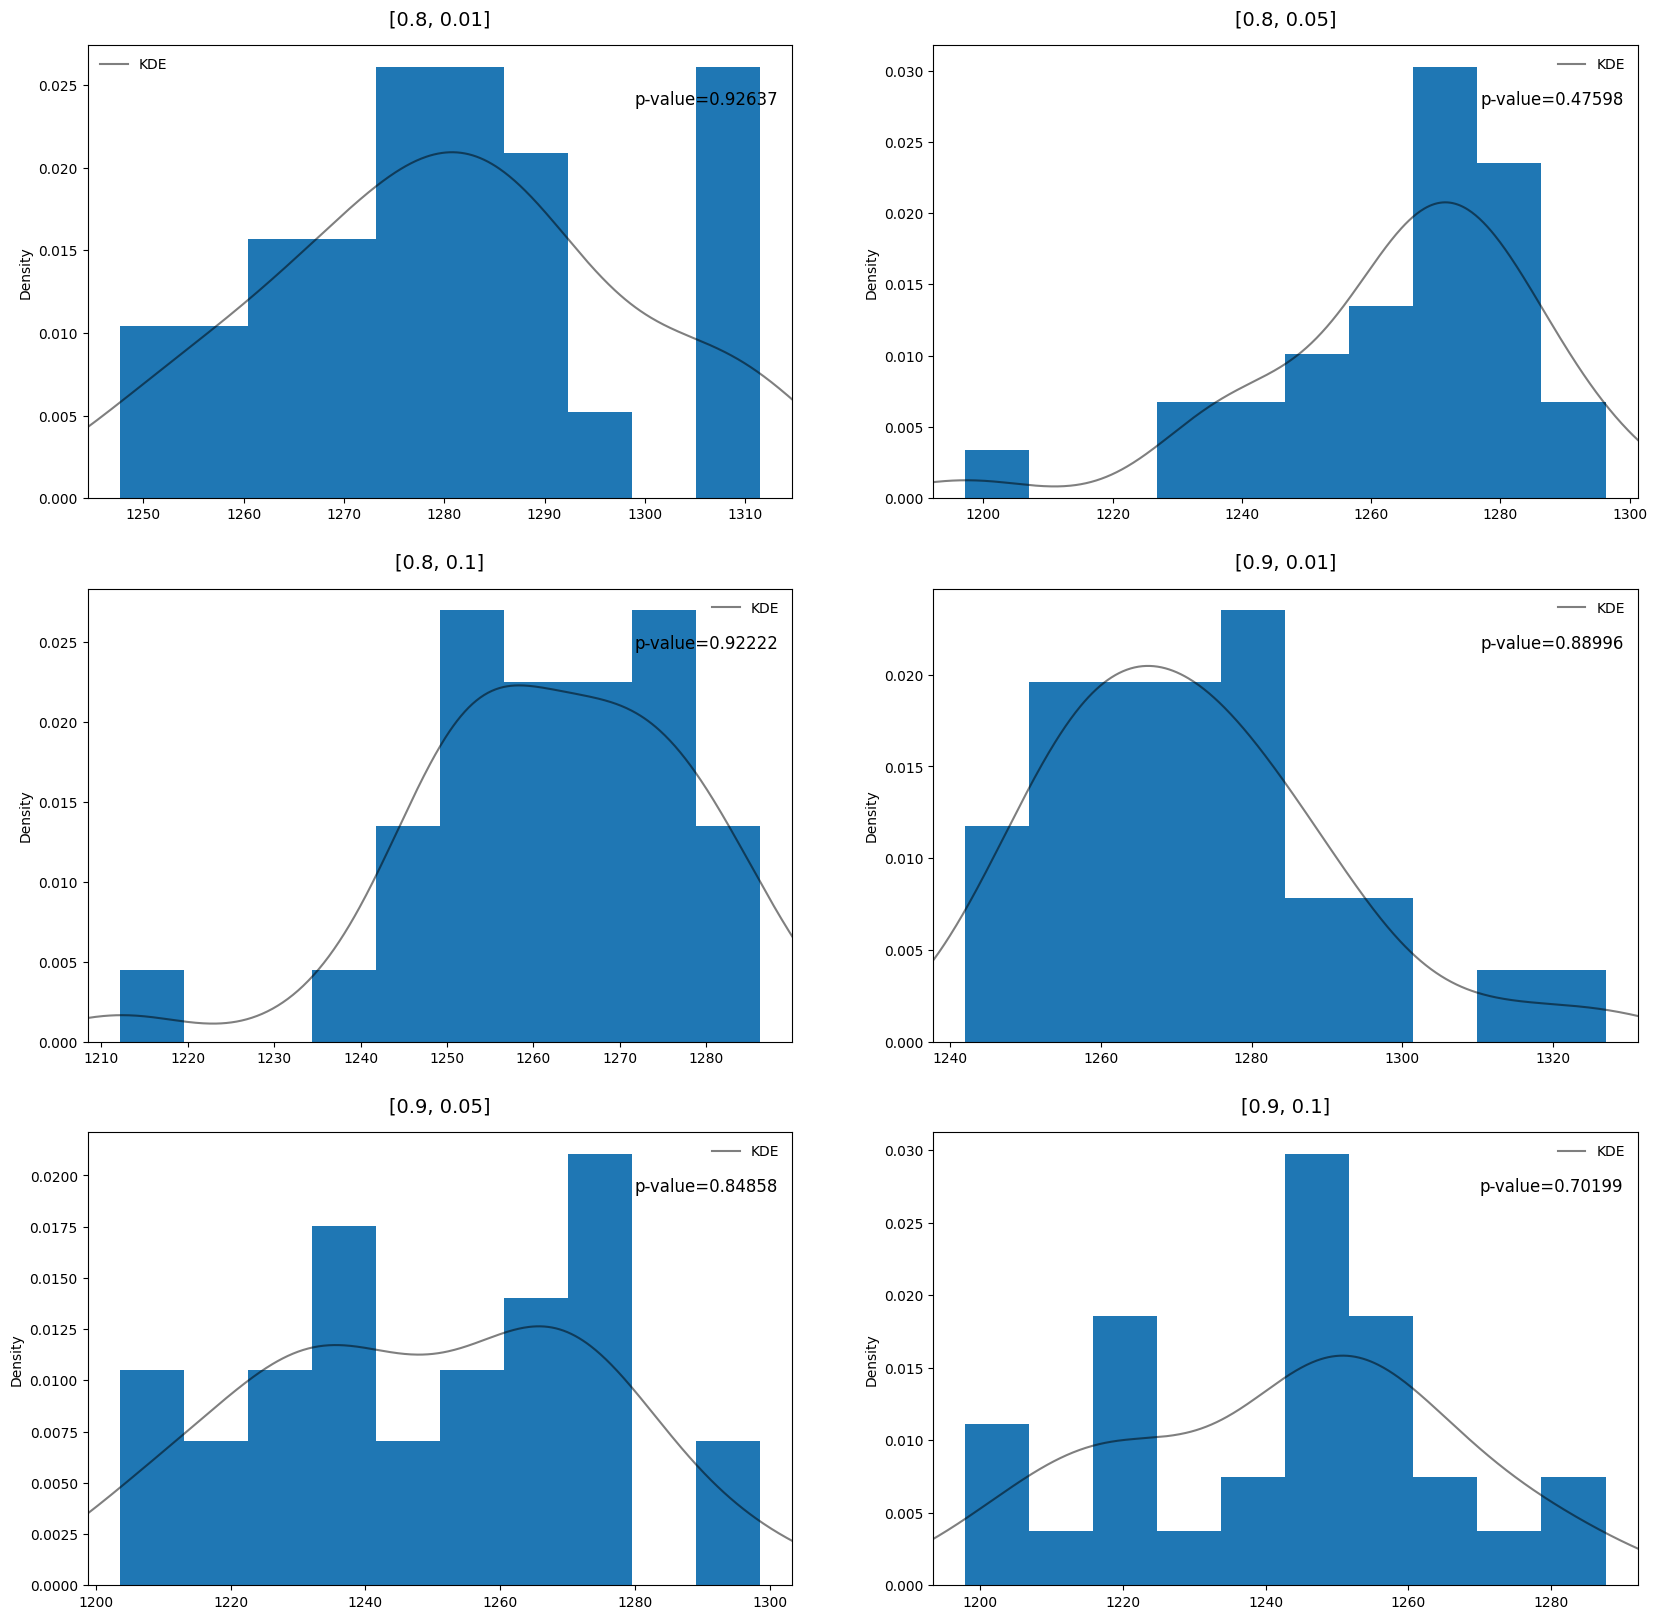

In [74]:
print_hist_plots(parametricos, "parametric")

In [75]:
f_oneway(*[parametricos[col] for col in parametricos.columns])

F_onewayResult(statistic=14.03663642461185, pvalue=1.575577368841548e-11)

The p-value turn out to be 1.5755e-11. <br>
Since the p-value is less than 0.05 hence we would reject the null hypothesis. <br>
This implies that we have sufficient proof to say that there exists a difference in the performance among four different configurations. 

In [76]:
import scikit_posthocs as ph
parametricos

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
0,1285.671766,1296.231587,1257.136032,1282.188690,1270.801786,1247.136131
1,1277.800476,1266.708730,1277.859544,1293.368016,1203.522421,1222.599365
2,1283.520714,1282.181905,1257.915040,1267.736964,1268.195933,1278.843651
3,1268.604563,1296.280893,1212.099583,1276.484762,1238.116230,1276.717440
4,1266.432718,1197.161528,1278.339365,1276.006925,1253.702222,1248.549722
5,1249.950357,1234.055437,1278.767579,1288.559782,1290.621786,1249.432738
6,1272.472083,1273.434504,1272.450298,1259.500536,1232.340774,1287.581607
7,1279.157956,1273.589028,1269.183472,1241.938532,1222.168849,1197.936944
8,1263.911488,1264.853948,1253.563353,1264.546190,1208.291786,1243.948294
9,1311.493810,1272.867599,1261.782143,1274.837540,1263.841012,1269.324603


In [77]:
#convert dataframe into a single column
fitness_by_method = parametricos.melt(var_name='parameters', value_name='best_fitness')
fitness_by_method

,parameters,best_fitness
0,"[0.8, 0.01]",1285.671766
1,"[0.8, 0.01]",1277.800476
2,"[0.8, 0.01]",1283.520714
3,"[0.8, 0.01]",1268.604563
4,"[0.8, 0.01]",1266.432718
...,...,...
175,"[0.9, 0.1]",1218.881627
176,"[0.9, 0.1]",1227.741012
177,"[0.9, 0.1]",1206.390020
178,"[0.9, 0.1]",1256.998393


In [78]:
#tstudent posthoc
posthoc = ph.posthoc_ttest(fitness_by_method, val_col='best_fitness', group_col='parameters', p_adjust='holm')
posthoc

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
"[0.8, 0.01]",1.000000e+00,0.018151,0.000669,0.279405,0.000009,2.566644e-08
"[0.8, 0.05]",1.815146e-02,1.000000,0.603387,0.499834,0.085718,2.846815e-03
"[0.8, 0.1]",6.690714e-04,0.603387,1.000000,0.147607,0.147607,4.044384e-03
"[0.9, 0.01]",2.794054e-01,0.499834,0.147607,1.000000,0.002484,2.060808e-05
"[0.9, 0.05]",9.193886e-06,0.085718,0.147607,0.002484,1.000000,6.033868e-01
"[0.9, 0.1]",2.566644e-08,0.002847,0.004044,0.000021,0.603387,1.000000e+00


The Nemenyi post-hoc test produces the p-values for each pairwise comparison of means. These values are: <br>
    P-value of [0.8, 0.01] vs. [0.8, 0.05] : 0.128313 <br>
    etc. <br>

For α = 0.05 there are only 5 groups that seem to have statistically significantly different means (p-value < 0.05). <br>
* [0.8, 0.01] vs [0.8, 0.1] : 0.002042   <br>
* [0.8, 0.01] vs [0.9, 0.05] : 0.001000 <br>
* [0.8, 0.01] vs [0.9, 0.1] : 0.001000 <br>
* [0.8, 0.05] vs [0.9, 0.1] : 0.004493 <br>
* [0.9, 0.01] vs [0.9, 0.1] : 0.001000 <br>



In [85]:
posthoc[posthoc < 0.05]

,"[0.8, 0.01]","[0.8, 0.05]","[0.8, 0.1]","[0.9, 0.01]","[0.9, 0.05]","[0.9, 0.1]"
"[0.8, 0.01]",NaN,0.018151,0.000669,NaN,0.000009,2.566644e-08
"[0.8, 0.05]",1.815146e-02,NaN,NaN,NaN,NaN,2.846815e-03
"[0.8, 0.1]",6.690714e-04,NaN,NaN,NaN,NaN,4.044384e-03
"[0.9, 0.01]",NaN,NaN,NaN,NaN,0.002484,2.060808e-05
"[0.9, 0.05]",9.193886e-06,NaN,NaN,0.002484,NaN,NaN
"[0.9, 0.1]",2.566644e-08,0.002847,0.004044,0.000021,NaN,NaN


In [86]:
configs = [ (r,c) for (r,c) in zip(*np.where(posthoc[posthoc < 0.05].notnull())) if r<c ]
configs

[(0, 1), (0, 2), (0, 4), (0, 5), (1, 5), (2, 5), (3, 4), (3, 5)]

In [87]:
resultados

,CXPB,MUTPB,best_historical_fitness,avg_best_fitness,std_fitness,avg_time,p-value
0,0.8,0.01,1255.752024,1280.579688,17.192971,441.956239,0.926373
1,0.8,0.05,1236.376905,1264.674286,20.579784,425.269461,0.475978
2,0.8,0.10,1236.761349,1261.774478,15.693523,431.654075,0.922218
3,0.9,0.01,1247.808671,1271.890869,18.606082,454.563961,0.889964
4,0.9,0.05,1243.522004,1249.125515,24.998969,466.454946,0.848576
5,0.9,0.10,1241.138274,1242.557732,22.955924,458.274806,0.701994


Como puede observarse en los resultados, tanto el mejor fitness histórico como promedio es mínimo para la combinación de [0.9, 0.10]. Existe evidencia para decir que esta combinacón es mejor que las demás con un nivel de confidencia del 0.05 excepto por [0.9, 0.05]. Aún así, se decide tomar [0.9, 0.10] dado que la diferencia en tiempo no es significativa y tuvo mejores resultados en los demás atributos.

https://eva.fing.edu.uy/pluginfile.php/357415/mod_resource/content/1/StatTests.pdf
diapo 21

In [82]:
#No entendi el codigo de acá para abajo, borre el test de tukey porque aca deberíamos usar el ttest que es para normales (es más certero que los no paramétricos)

df = pd.DataFrame({'values': parametricos.values.flatten(),
                   'group': np.tile(parametricos.columns, (1, 30))[0]}) 

In [83]:
for col in parametricos.columns:
    print( np.array_equal(df[df["group"] == col]["values"].values, parametricos[col].values) )

True
True
True
True
True
True
